# CSII 2024 Exercise 10: $H_{\infty}$ Control
&copy; 2024 ETH Zurich, Niclas Scheuer, Roy Werder, Dejan Milojevic, Pierre Suter, Stephan König ; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

## Description
This week's Jupyter notebook will include a small recap of the $H_{\infty}$ norm and an introduction to $H_2$ and $H_{\infty}$ control.


-------

## Installation
We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`, which can be installed using `pip`. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search.

If you have done all the Jupyter Notebooks leading up to this one, you should have all the necessary libraries installed. 



In [ ]:
# Install the required python library with pip
%pip install cs2solutions --force-reinstall

-------

## Python Libraries

We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.

In [ ]:
# Import the required python libraries
from typing import Optional, List, Tuple
from cs2solutions import H_inf
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import scipy.linalg as la
np.set_printoptions(precision=6, suppress=True, linewidth=200)

This is the function used last week:


In [ ]:
def systemInfnorm(system: ct.TransferFunction) -> float:
    """
    Returns an approximation of the infinity norm of the system

    Parameters:
    - ``system`` (ct.TransferFunction): The system to compute the infinity norm of

    Returns:
    - float: The infinity norm of the system
    """
    # Create a range of frequencies to analyze over
    omega = np.linspace(-4, 4, 1000)
    H = system(omega * 1j)

    # Consider the MIMO case
    if system.ninputs > 1 or system.noutputs > 1:
        # Calculate singular values
        singular_values = [np.linalg.svd(H[..., i])[1] for i in range(len(omega))]
    # Consider the SISO case
    else:
        singular_values = [np.absolute(H[..., i]) for i in range(len(omega))]

    # Return the highest singular value
    return np.vstack(singular_values).max()

------

## Exercise 1:

As a recap from the last two weeks we will first calculate the $H_{\infty}$ norm via the state-space representation. The solution via the transfer function as introduced last week is given to check your own implementation.

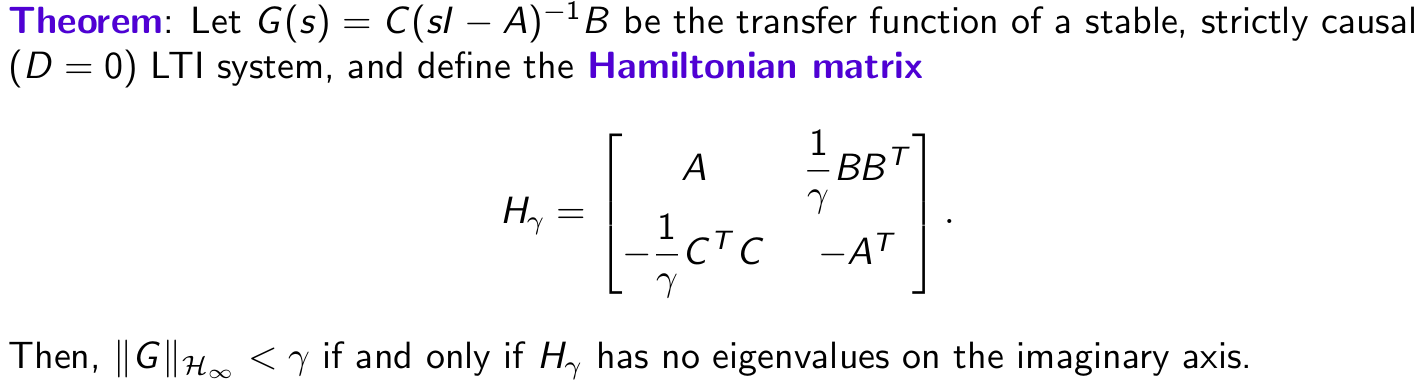

In [ ]:
def H_inf_norm_state_space(A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray) -> float:
    """
    Returns the infinity norm of the system defined by the state space matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``C`` (np.ndarray): The output matrix of the system
    - ``D`` (np.ndarray): The feedthrough matrix of the system

    Returns:
    - float: The infinity norm of the system
    """
    
    gamma = 1
    
    return gamma

### Solution 1
The function ``test_H_inf_norm_state_space`` below checks whether the student solution matches the master solution.

In [ ]:
H_inf.test_H_inf_norm_state_space(H_inf_norm_state_space, H_inf.sol_H_inf_norm_state_space)

Below, you can verify that the _state-space_ and _transfer function_ implementations of the $H_{\infty}$ norm are equivalent.

In [ ]:
# Define the state space matrices. Feel free to change these to test the function. It also works for MIMO systems.
A = np.array([[0, 1], [-2, -1]])
B = np.array([[0], [1]])
C = np.array([[2, 1]])
D = np.array([[0]])

# Calculate the infinity norms using the method introduced last week
tf = ct.ss2tf(A, B, C, D)
tf_norm = systemInfnorm(tf)

# Calculate the infinity norm using the state space method
ss_norm = H_inf_norm_state_space(A, B, C, D)

# Print the results
print(f"Transfer function infinity norm: {tf_norm}")
print(f"State space infinity norm: {ss_norm}")
if np.isclose(tf_norm, ss_norm, rtol=1e-2):
    print("The infinity norms match!")
else:
    print("The infinity norms do not match!")

------

## Exercise 2a:
You are working as a controls engineer at Autobau AG. It is your job to design a laneholding assistant. Because the lanes are denoted by striped lines (akin to this -----), the input data is noisy. As your first assignment you are tasked with coming up with an **optimal observer gain $L$** for your system, which looks as following.

$\dot{x}(t)=Ax(t)+B_ww(t)+B_uu(t) $

$z(t)=C_zx(t)+D_{zw}w(t)+D_{zu}(t) $

$y(t)=C_yx(t)+D_{yw}w(t)+D_{yu}u(t) $

Furthermore you can assume all initial conditions to be zero and also that $B_u = I$. You find the actual matrices below, but feel free to change them and test your own matrices.

In [ ]:
A=np.array([[-10, 12, -1], [-1, 1.25, -2], [1, 0, -5]])

B_w=np.array([[0, 1, -4], [-1, 0, 2], [0, -1, 1]])
B_u=np.eye(3)

C_z=np.array([[1, 0, -1], [1, 0, 8], [0, 6, 1]])
C_y=np.eye(3)

D_zw=np.zeros((3,3))
D_zu=np.array([[-1, 0, -1], [2, 1, -3], [1, 10, 3]])
D_yw=np.array([[1, 0, 3], [6, 1, -0.5], [-1, 0, 1]])
D_yu=np.zeros((3,3))

You recall from your Control Systems II lecture that the optimal observer gain L is defined as:

$L = -(YC_y + B_w D_{yw}')R_{ww}^{-1}$

... where $Y_L$ is determined using a modified continous _algebraic riccati equation_:

$(A - B_wD_{yw}'R_{ww}^{-1}C_y)'Y + Y(A - B_wD_{yw}'R_{ww}^{-1}C_y) - YC_yR_{ww}^{-1}C_y'Y + B_w(I - D_{yw}'R_{ww}^{-1}D_{yw})B_w'=0$

_(Formulas and derivations found "Lecture 10: Modern Control Synthesis: $H_2, H_{\infty}, \mu$-synthesis)", slides 10-13_


It is **highly** recommended to use the scipy.linalg function [``la.solve_continous_are``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_continuous_are.html)

In [ ]:
def solve_riccati_equation(A: np.ndarray, B_w: np.ndarray, C_y: np.ndarray, R_ww: np.ndarray, D_yw: np.ndarray) -> np.ndarray:
    """
    Returns the solution to the continuous algebraic Riccati equation

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B_w`` (np.ndarray): The disturbance input matrix of the system
    - ``C_y`` (np.ndarray): The output matrix of the system
    - ``R_ww`` (np.ndarray): The disturbance covariance matrix
    - ``D_yw`` (np.ndarray): The feedthrough matrix from the disturbance to the output
    - ``Q`` (np.ndarray): The state cost matrix

    Returns:
    - np.ndarray: The solution to the continuous algebraic Riccati equation
    """
    a = #TODO
    b = #TODO
    q = #TODO
    r = #TODO
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    Y = la.solve_continuous_are(a, b, q, r)
    return Y
    

In [ ]:
def optimal_LQE(A: np.ndarray, B_w: np.ndarray, C_y: np.ndarray, D_yw: np.ndarray) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """
    R_ww = D_yw @ D_yw.T
    Y = solve_riccati_equation(A, B_w, C_y, R_ww, D_yw)
    L = #TODO
    
    return L

### Solution 2a:

Find below some checks to determine whether your function implementation is correct.

In [ ]:
H_inf.test_solve_riccati_equation(solve_riccati_equation, H_inf.sol_solve_riccati_equation)
H_inf.test_optimal_LQE(optimal_LQE, H_inf.sol_optimal_LQE)

Finally, print the optimal observer gain using your function or the solution function:

In [ ]:
L_optimal = optimal_LQE(A, B_w, C_y, D_yw)
# L_optimal = H_inf.sol_optimal_LQE(A, B_w, C_y, D_yw)
print("The optimal state feedback gain is:")
print(L_optimal)

## Exercise 2b: 
Similarly, the optimal controller gain can be solved using the LQR formulation presented in the slides:

$F = -(D_{zu}'D_{zu})^{-1}B_u'X_F$

... where $X_F$ is found using an _algebraic riccati equation_:

$A'X_F + X_FA+ X_FB_u(D_{zu}'D_{zu})^{-1}B_u'X_F + C_z'C_z=0$

_(Formulas and derivations found "Lecture 10: Modern Control Synthesis: $H_2, H_{\infty}, \mu$-synthesis)", slides 5-6_

It is **highly** recommended to use the scipy.linalg function [``la.solve_continous_are``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_continuous_are.html)

In [ ]:
def optimal_LQR(A: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, D_zu: np.ndarray) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """
    a = #TODO
    b = #TODO
    q = #TODO
    r = #TODO
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    X_F = la.solve_continuous_are(a, b, q, r)
    F = #TODO
    
    return F

### Solution 2b:

Below are some checks to determine if your implementation is correct.

In [ ]:
H_inf.test_optimal_LQR(optimal_LQR, H_inf.sol_optimal_LQR)

Finally, print the optimal controller gain using your function or the solution function:

In [ ]:
F_optimal = optimal_LQR(A, B_u, C_z, D_zu)
# F_optimal = H_inf.sol_optimal_LQR(A, B_u, C_z, D_zu)
print("Optimal controller gain:")
print(F_optimal)

## Exercise 2c: 
Great, you managed to impress your project manager by coming up with an optimal observer for the LQG problem and controller for the LQR problem. 

Using the controller and observer gains $F$ and $L$ calculated earlier, he wants you to find an $H_2$-optimal controller as denoted by $K$.

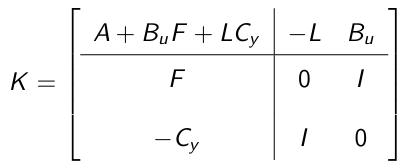

The function [``np.block``](https://numpy.org/doc/stable/reference/generated/numpy.block.html) may be of use in this exercise.

In [ ]:
def optimal_controller(A: np.ndarray, B_w: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, C_y: np.ndarray, D_zw: np.ndarray, D_zu: np.ndarray, D_yw: np.ndarray, D_yu: np.ndarray) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """
    # Find the optimal observer gain
    L = optimal_LQE(A, B_w, C_y, D_yw)
    
    # Find the optimal controller gain
    F = optimal_LQR(A, B_u, C_z, D_zu)
    
    A_K = #TODO
    B_K = #TODO
    C_K = #TODO
    D_K = np.block([
        [np.zeros((F.shape[1], L.shape[0])), np.ones((F.shape[1], B_u.shape[1]))], 
        [np.ones((C_y.shape[0], L.shape[0])), np.zeros((C_y.shape[0], B_u.shape[1]))]])
    
    K = #TODO
    
    return K, A_K, B_K, C_K, D_K

### Solution 2c:
Check your solution against the master solution.

In [ ]:
H_inf.test_optimal_controller(optimal_controller, H_inf.sol_optimal_controller)

Use your implementation or the solution to print the controller.

In [ ]:
K, A_K, B_K, C_K, D_K = optimal_controller(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu)
# K, A_K, B_K, C_K, D_K = H_inf.sol_optimal_controller(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu)
print("Optimal H_2 controller: \n", K)

print("In state space form:")
print("A_K:\n", A_K)
print("B_K:\n", B_K)
print("C_K:\n", C_K)
print("D_K:\n", D_K)

h_inf_norm = H_inf_norm_state_space(A_K, B_K, C_K, D_K)
print(f"The H_inf norm of the optimal controller is: {h_inf_norm}")

------

## Exercise 3:

Now we will use the same system as before to find a suboptimal $H_{\infty}$ controller. For simplicity you can also assume **$\gamma = 0.5$**.

Solving for $X_{\infty}$ and $Y_{\infty}$ using two _continuous algebraic riccati equations_:

$X_{\infty}A + A^TX_{\infty} + X_{\infty}(\frac{1}{\gamma^2}B_wB_w^T - B_uB_u^T)X_{\infty}+C_z^TC_Z=0$

$AY_{\infty} + Y_{\infty}A^T + Y_{\infty}(\frac{1}{\gamma^2}C_zC_z^T - C_yC_y^T)Y_{\infty} + B_w^TB_w = 0$

The controller matrix is defined as follows:

$F_{\infty} = -B_u^TX_{\infty}$

$L_{\infty} = -Y_{\infty}C_y^T$

$Z_{\infty} = (I - \frac{1}{\gamma^2}X_{\infty}Y_{\infty})^{-1}$

$K = \begin{bmatrix}
A + \frac{1}{\gamma^2}B_wB_w^TX_{\infty} + B_wF_{\infty} + Z_{\infty}C_y & -Z_{\infty}L_{\infty} \\
F_{\infty} & 0 
\end{bmatrix}  $

More information on [Wikipedia](https://de.wikipedia.org/wiki/H-unendlich-Regelung).

In [ ]:
gamma = 0.5

In [ ]:
def find_X_inf(A: np.ndarray, B_w: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, gamma: float) -> np.ndarray:
    """
    Returns the infinity norm of the system defined by the state space matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``C`` (np.ndarray): The output matrix of the system
    - ``D`` (np.ndarray): The feedthrough matrix of the system

    Returns:
    - float: The infinity norm of the system
    """
    a = #TODO
    b = #TODO
    q = #TODO
    r = np.linalg.inv(1/gamma**2*B_w@B_w.T-B_u@B_u.T)
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    X = la.solve_continuous_are(a, b, q, r)
    return X
    

In [ ]:
def find_Y_inf(A: np.ndarray, B_w: np.ndarray, C_z: np.ndarray, C_y: np.ndarray, gamma: float) -> np.ndarray:
    """
    Returns the infinity norm of the system defined by the state space matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``C`` (np.ndarray): The output matrix of the system
    - ``D`` (np.ndarray): The feedthrough matrix of the system

    Returns:
    - float: The infinity norm of the system
    """
    a = #TODO
    b = #TODO
    q = #TODO
    r = np.linalg.inv(1/gamma**2*C_z@C_z.T-C_y@C_y.T)
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    Y = la.solve_continuous_are(a, b, q, r)
    return Y

The function [``np.block``](https://numpy.org/doc/stable/reference/generated/numpy.block.html) may be of use in this exercise.

In [ ]:
def assemble_suboptimal_K(A: np.ndarray, B_w: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, C_y: np.ndarray, D_zw: np.ndarray, D_zu: np.ndarray, D_yw: np.ndarray, D_yu: np.ndarray, gamma: float) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """    
    # Find the suboptimal X_inf and Y_inf
    X_inf = find_X_inf(A, B_w, B_u, C_z, gamma)
    Y_inf = find_Y_inf(A, B_w, C_z, C_y, gamma)
    
    # Find the suboptimal gains
    F_inf = #TODO
    L_inf = #TODO
    
    # Define helper matrices
    Z_inf = #TODO
    
    # Assemble the suboptimal controller
    A_K_suboptimal = #TODO
    B_K_suboptimal = #TODO
    C_K_suboptimal = #TODO
    D_K_suboptimal = np.zeros((F_inf.shape[0], L_inf.shape[1]))
    
    K = #TODO
    
    return K, A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal

### Solution 3:

Verify/Update your solutions using the master solutions below.

In [ ]:
H_inf.test_find_X_inf(find_X_inf, H_inf.sol_find_X_inf)
H_inf.test_find_Y_inf(find_Y_inf, H_inf.sol_find_Y_inf)
H_inf.test_assemble_suboptimal_K(assemble_suboptimal_K, H_inf.sol_assemble_suboptimal_K)

Finally use your implementation or the solution to find the $H_{\infty}$ controller.

In [ ]:
gamma = 0.5 # Initial
K_suboptimal, A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal = assemble_suboptimal_K(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu, gamma)
# K_suboptimal, A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal = H_inf.assemble_suboptimal_K(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu, gamma)
print("Suboptimal H_2 controller: \n", K_suboptimal)

# H_inf norm of the system
H_inf_norm = H_inf_norm_state_space(A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal)
print("H_inf norm of the system: ", H_inf_norm)
